# Nested Sampling - Integration with Style
In this document, we use JAXNS to get evidence from a simple NumPyro model, investigating the effects of tuning parameters and making use of the utility functions provided in JAXNS' NumPyro implementation.

First up, we import all the relevant packages:

**todo**

## How Nested Sampling Works

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Phasellus massa leo, condimentum eget vehicula id, mollis et diam. Proin sodales tortor at sollicitudin convallis. Aenean malesuada commodo metus, eget vehicula erat ultrices a. In fermentum bibendum sagittis. Pellentesque sit amet erat quis nisi pharetra lacinia. Duis sagittis sapien id purus condimentum tristique. Nam sit amet elit non nisl placerat rhoncus eu non justo. Quisque ut aliquet orci. Maecenas viverra pharetra nisl, et tempus nisi convallis feugiat. Etiam eros felis, feugiat et cursus a, ornare eget sem. Quisque a condimentum orci. Morbi massa enim, aliquet id est ac, tincidunt ullamcorper urna.

- Put walkthrough here

**Building a Toy Problem**
- First going to make a simple toy problem to see how this works

In [3]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer

- Look at a simple toy problem of a bimodal gaussian in 2D
- For the sake of comparison, round this to have a _known_ integral of $Z_{true} = 3.0$

In [398]:
Ztrue = 3.0

def prob_func(x,y):
    # Two gaussian modes
    out=0
    out+=jnp.exp(-(x - 2)**2-y**2) 
    out+=jnp.exp(-(x + 2)**2-y**2)

    # Normalizing
    out/=2*np.pi
    out*=Ztrue
    return(out)
    
def log_prob_func(x,y):
    return(jnp.log(prob_func(x,y)))

- In a toy case like this, integration is obviously tractable through simple brute force, but keep in mind that integration scales exponentially with dimension, and often involves expensive evaluations

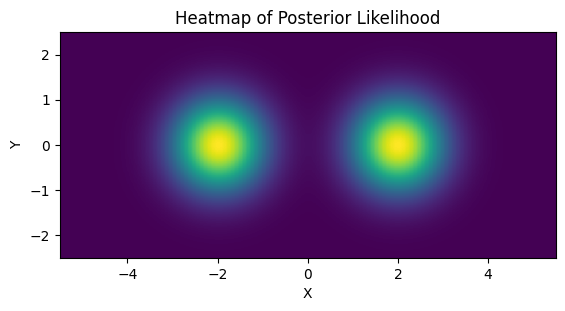

Evidence from grid integration is 0.8122, an error of 72.93% with 16384 evaluations


In [402]:
#---------------------
# Set prior boundary
xmin,xmax = -5.5, 5.5
ymin,ymax = -2.5,2.5
V0 = (xmax-xmin) * (ymax-ymin)

#---------------------
# Generate Heatmap
Ngrid = 128
dx, dy = (xmax-xmin)/(Ngrid-1), (ymax-ymin)/(Ngrid-1)
Xgrid, Ygrid = np.meshgrid(np.linspace(xmin,xmax,Ngrid), np.linspace(ymin,ymax,Ngrid))
heatmap_grid =prob_func(Xgrid,Ygrid)

#---------------------
# Plot heatmap
def do_heatmap(cmap = 'viridis', contrast = 1, clipping=[0,1], interpolation = 'antialiased'):
    fig, ax = plt.subplots(1,1)
    ax.imshow(heatmap_grid**contrast, extent=[xmin,xmax,ymin,ymax], 
              cmap = cmap, 
              vmin = heatmap_grid.max()*clipping[0], 
              vmax = heatmap_grid.max()*clipping[1], 
              interpolation = interpolation,
              zorder=-10)
    ax.set_title("Heatmap of Posterior Likelihood")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    return(fig, ax)
fig, ax = do_heatmap()
plt.show()

#---------------------
Zgrid = np.sum(Lgrid) / np.sum(Lgrid>0) * V0
print("Evidence from grid integration is %0.4f, an error of %0.2f%% with %i evaluations" %(Zgrid,abs(Zgrid/Ztrue-1)*100, Ngrid**2) )

**A (Very Rough) Nested Sampling Implementation**

- [MISSINGNO]
- Start by making a list of "live points", randomly distributed across the prior, sorting them in order of likelihood

Drawing random Samples


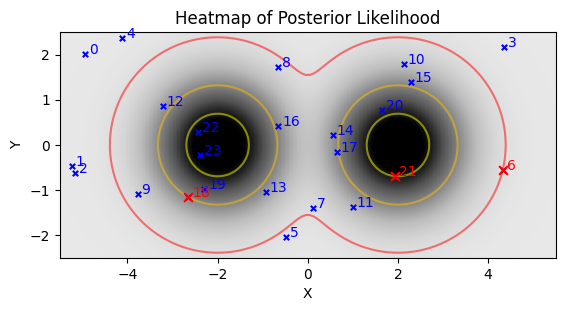

In [493]:
Nlive = 24
Nevals = Nlive*4
plot_sparse = 6

np.random.seed(3)
# Draw random samples from the prior
print("Drawing random Samples")
Xlive = np.random.rand(Nlive)*(xmax-xmin) + xmin
Ylive = np.random.rand(Nlive)*(ymax-ymin) + ymin
Llive = prob_func(Xlive, Ylive)

def sort_livepoints(X,Y,L):
    Isort=np.argsort(L)
    return(X[Isort], Y[Isort], L[Isort])
Xlive,Ylive,Llive = sort_livepoints(Xlive, Ylive, Llive)

Ihilight = np.percentile(np.arange(Llive.size), [25, 80, 90], method='nearest')
Lhilight = Llive[Ihilight]
Xhilight = Xlive[Ihilight]
Yhilight = Ylive[Ihilight]

#-------------------------------------------------
fig, ax = do_heatmap('Greys', contrast = 0.5, clipping = [-0.25, 1.25])
ax.contour(Xgrid, Ygrid, np.log(heatmap_grid), levels = np.log(Lhilight), cmap='autumn', zorder=-1, alpha=0.5)
ax.scatter(Xlive, Ylive,c='b', s=15, marker = 'x')
ax.scatter(Xhilight, Yhilight, c='r', s=40, marker = 'x')

for i in range(Nlive):
    if i in Ihilight:
        c = 'r' 
    else:
        c = 'b'
    ax.annotate(i, (Xlive[i]+dx, Ylive[i]), color=c)

    
plt.show()

Generatting stepped potential
1 0.28198242
2 0.15722656
3 0.061279297
Plotting heatmap
Doing 3D plot


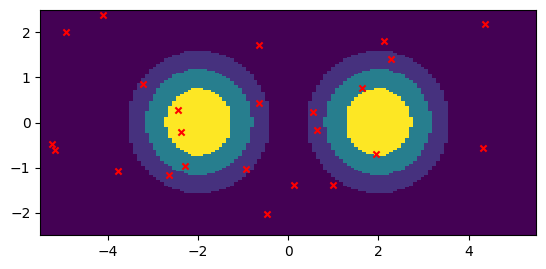

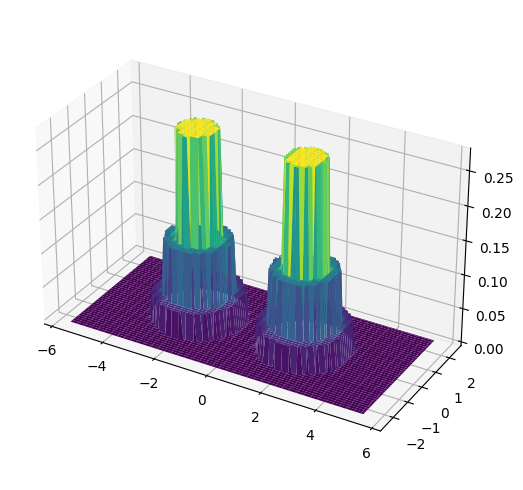

In [495]:
{
    "tags": [
        "hide-input",
    ]
}
def make_steps(X, L):
    lprev = 0
    out = np.zeros_like(X)
    i=0
    for l in L:
        i+=1
        I = (X>=l)
        out[np.where(X>=l)] = l
        print(i, np.sum(I) / X.size)
        lprev = l
    return(out)
print("Generatting stepped potential")
_levels = np.percentile(Llive, [50, 80, 90])
heatmap_stepped = make_steps(heatmap_grid, _levels )

print("Plotting heatmap")
plt.imshow(heatmap_stepped, extent = [xmin,xmax,ymin,ymax], interpolation = 'none')
plt.scatter(Xlive, Ylive, c='red', s = 20, zorder=1, marker='x')

print("Doing 3D plot")
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(5,5))
surf = ax.plot_surface(Xgrid, Ygrid, heatmap_stepped, cmap='viridis',
                       linewidth=0, antialiased=True, zorder=-1)

#ax.set_zlim(0, heatmap_stepped.max()*1.5)
ax.set_aspect('equalxy')
fig.tight_layout()

plt.show()

In [342]:
_Z.argsort()

array([11153, 11138, 11139, ...,  7459,  7460,  7461])

Doing 3D plot


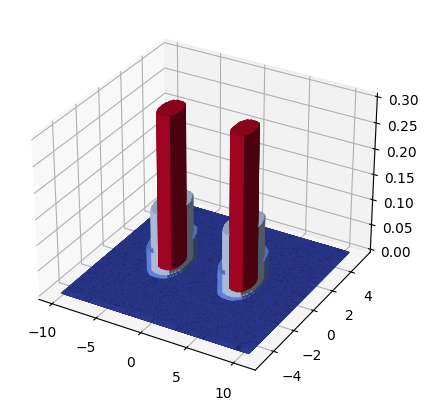

Done


In [364]:
_Z = heatmap_stepped.ravel()
_x = Xgrid.ravel()
_y = Ygrid.ravel()


print("Doing 3D plot")
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(5,5))
ax.bar3d(_x, _y, np.zeros_like(_Z), dx*5, dy*5, _Z, shade=True, color = plt.cm.coolwarm(_Z/_Z.max())[::-1])
plt.show()
print("Done")


Drawing random Samples
	 Itteration 0/4000 done, new highest prob: 0.000000
	 Itteration 200/4000 done, new highest prob: 0.000000
	 Itteration 400/4000 done, new highest prob: 0.000012
	 Itteration 600/4000 done, new highest prob: 0.001138
	 Itteration 800/4000 done, new highest prob: 0.020894
	 Itteration 1000/4000 done, new highest prob: 0.090270
	 Itteration 1200/4000 done, new highest prob: 0.185161
	 Itteration 1400/4000 done, new highest prob: 0.278618
	 Itteration 1600/4000 done, new highest prob: 0.359123
	 Itteration 1800/4000 done, new highest prob: 0.417867
	 Itteration 2000/4000 done, new highest prob: 0.443127
	 Itteration 2200/4000 done, new highest prob: 0.458515
	 Itteration 2400/4000 done, new highest prob: 0.467934
	 Itteration 2600/4000 done, new highest prob: 0.472579
	 Itteration 2800/4000 done, new highest prob: 0.474889
	 Itteration 3000/4000 done, new highest prob: 0.476094
	 Itteration 3200/4000 done, new highest prob: 0.476759
	 Itteration 3400/4000 done, new

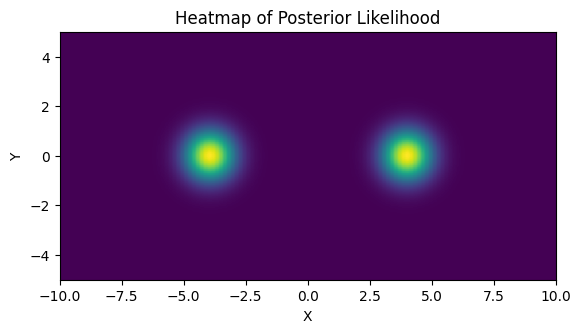

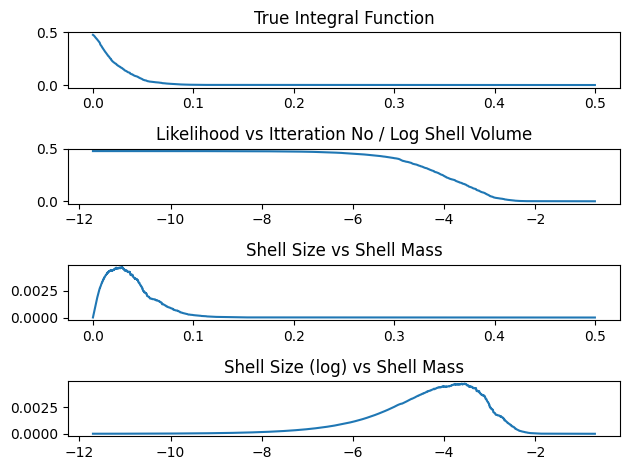

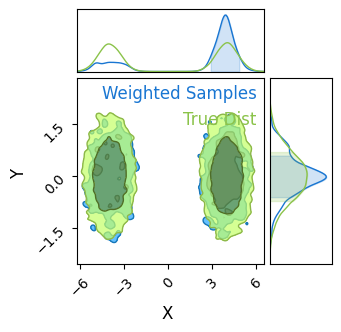

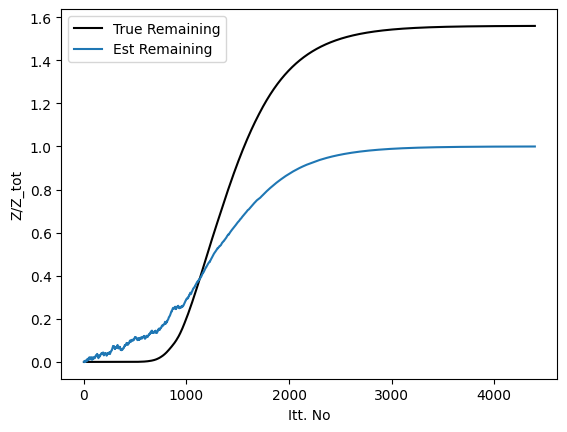

In [20]:

# Plot
# Plot heatmap
fig1,ax1 = plt.subplots(1,1)
ax1.imshow(Lgrid, extent=[xmin,xmax,ymin,ymax])
ax1.set_title("Heatmap of Posterior Likelihood")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")

ax[1].scatter(Xlive,Ylive, c='r', marker='x')

Xchain = np.zeros(Nevals)
Ychain = np.zeros(Nevals)
Lchain = np.zeros(Nevals)

total_evals = Nlive

#Perform loop
propmethod = 'stretchmove'
for k in range(Nevals):
    lmin = Llive[0]
    l = lmin-1

    #--------------------
    # PROPOSAL GENERATION
    #Draw new random samples until we get one with L>Lmin

    if propmethod == 'unitcube':
        xmin_live, xmax_live =xmin, xmax
        ymin_live, ymax_live =ymin, ymax
    elif propmethod == 'boundedcube':
        xmin_live, xmax_live =min(Xlive), max(Xlive)
        ymin_live, ymax_live =min(Ylive), max(Ylive)

    while l<=lmin:
        if 'cube' in propmethod:
            x, y = np.random.rand()*(xmax_live-xmin_live) + xmin_live, np.random.rand()*(ymax_live-ymin_live) + ymin_live
        else:
                
            i1, i2 = np.random.randint(Nlive), np.random.randint(Nlive)
            x1, y1 = Xlive[i1], Ylive[i1]
            x2, y2 = Xlive[i2], Ylive[i2]

            if propmethod == 'stretchmove':
                r = np.random.rand() * (8**0.5-8**-0.5) + 8**-0.5
                z = r**(2/3)

                x, y = x1 + (x2-x1) * z, y1 + (y2-y1) * z
            
        l = prob_func(x,y)
        total_evals+=1

    #--------------------

    Xchain[k] = Xlive[0]
    Ychain[k] = Ylive[0]
    Lchain[k] = Llive[0]

    #Pop Lmin from our live points and add the new good one
    Xlive[0], Ylive[0], Llive[0] = x, y, l



    if Llive[0]>Llive[1]:
        Isort=np.argsort(Llive)
        Xlive, Ylive, Llive = Xlive[Isort], Ylive[Isort], Llive[Isort]

    #Store the new probability in the chain

    if k%(Nevals//20) == 0: print('\t Itteration %i/%i done, new highest prob: %f' %(k,Nevals,Lchain[k]))

#Add remaining chain points
Isort=np.argsort(Llive)
Xlive, Ylive, Llive = Xlive[Isort], Ylive[Isort], Llive[Isort]

Xchain = np.concatenate([Xchain,Xlive])
Ychain = np.concatenate([Ychain, Ylive])
Lchain = np.concatenate([Lchain, Llive])

print("NS chain complete.")
print("Total number of evaluations: %i" %total_evals)
print("Compared to: %i" %Nplot**2)
print("Ratio of: %0.4f %%" %(total_evals/Nplot**2 * 100))
print("Acceptance Ratio of Samples: %0.4f %%" %(len(Lchain)/total_evals*100))

ax[1].scatter(Xchain, Ychain, c='grey', marker='.', alpha = 0.15, s=5)
ax[1].scatter(Xlive, Ylive, c='limegreen', marker='o', alpha = 0.25)

ax[1].set_xlim(xmin,xmax)
ax[1].set_ylim(ymin,ymax)

#--------------------------
# Calculate & compare evidence integrals
V0 = (xmax-xmin) * (ymax-ymin)
V = V0 * (1-1/Nlive) ** np.arange(0,len(Lchain))
dV = np.abs(V[1:]-V[:-1])

# Newtonian integration from grid
dx      = (xmax-xmin) / (Nplot-1)
dy      = (ymax-ymin) / (Nplot-1)
Z_grid  = np.sum(Lplot)*dx*dy

# Estimate from nested sampling
Z_nest_1 = 0
Z_nest_2 = 0

Z_nest_1 = np.sum(np.abs(Lchain[1:]-Lchain[:-1]) * V[1:])
Z_nest_2 = np.sum(Lchain[1:]*dV)

#--------------------------

print("\n")
print("Evidence From")
print("Direct grid integral:\t%f" %Z_grid)
print("Nested Sampling, First Integral:\t%f" %Z_nest_1)
print("Nested Sampling, Second Integral:\t%f" %Z_nest_2)

print("\n")
truth = 3.0
print("Relative Errors")
print("Direct grid integral:\t%f" %abs(Z_grid/truth-1))
print("Nested Sampling, First Integral:\t%f" %abs(Z_nest_1/truth-1))
print("Nested Sampling, Second Integral:\t%f" %abs(Z_nest_2/truth-1))

fig2, ax2 = plt.subplots(4,1)

ax2[0].plot(dV,          Lchain[1:]          )
ax2[0].set_title("True Integral Function")

ax2[1].plot(np.log(dV),  Lchain[1:]  )
ax2[1].set_title("Likelihood vs Itteration No / Log Shell Volume")

ax2[2].plot(dV,  dV * Lchain[1:]      )
ax2[2].set_title("Shell Size vs Shell Mass")

ax2[3].plot(np.log(dV),  dV * Lchain[1:]      )
ax2[3].set_title("Shell Size (log) vs Shell Mass")

fig2.tight_layout()

#--------------------------
# Attempt at importance sampling
Lnorm = (Lchain[1:] + Lchain[:-1])/2 
W = dV*Lnorm
W/=np.max(W)

Nsample = 10000

Xsample = np.zeros(Nsample)
Ysample = np.zeros(Nsample)

Isample = np.zeros(Nsample,dtype='int32')-1

for i in range(Nsample):
    while Isample[i]==-1:
        #choose a random unweighted point
        j = np.random.randint(len(W))
        w = W[j]
        r = np.random.rand()

        if w>=r:
            Isample[i]=j

Xsample = Xchain[1:][Isample]
Ysample = Ychain[1:][Isample]

ax[2].scatter(Xsample, Ysample, alpha=W*0.5*(max(Nsample/len(Lchain),1))**-1, s=5, c='r')

ax[2].axhline(np.mean(Ysample), ls='-', c='k')
ax[2].axvline(np.mean(Xsample), ls='-', c='k')

ax[2].axhline(np.mean(Ysample)+np.std(Ysample), ls='--', c='k')
ax[2].axhline(np.mean(Ysample)-np.std(Ysample), ls='--', c='k')

ax[2].axvline(np.mean(Xsample)+np.std(Xsample), ls='--', c='k')
ax[2].axvline(np.mean(Xsample)-np.std(Xsample), ls='--', c='k')

Ntruth=10000
Xtruth = np.zeros(Ntruth)
Ytruth = np.zeros(Ntruth)

print("Brute forcing sampling of the posterior")
for i in range(Ntruth):
    if i%(Ntruth//20) == 0:
        print("\t Sample %i of %i" %(i, Ntruth))
    use = False

    while use==False:
            x, y = np.random.rand()*(xmax-xmin) + xmin, np.random.rand()*(ymax-ymin) + ymin
            l = prob_func(x,y)
            r = np.random.rand()
            if l/np.max(Lplot) > r:
                use=True
                Xtruth[i], Ytruth[i] = x, y

c = ChainConsumer()
c.add_chain(chain = {'X':Xsample,'Y':Ysample}, name='Weighted Samples')
c.add_chain(chain = {'X':Xtruth, 'Y':Ytruth}, name='True Dist')
c.plotter.plot()

#--------------------------
# Remaining Evidence Estimations
Vnorm = (V[1:] + V[:-1])/2 
Z_running = np.array([np.sum((Lnorm*dV)[:i]) for i in range(len(Lnorm))])
Z_rem = Z_running/ (Z_running + Lnorm*Vnorm)

figrem, axrem = plt.subplots(1,1)
axrem.plot(Z_running/truth, label = 'True Remaining', c='k')
axrem.plot(Z_rem, label = 'Est Remaining')
axrem.legend()
axrem.set_xlabel("Itt. No")
axrem.set_ylabel("Z/Z_tot")

plt.show()


## Nested Sampling In NumPyro with JAXNS
So far, we've seen that none of NumPyro's native MCMC samplers work particularly well in multimodal distributions. Though they may locate the modes decently well, they fail to sample from them in a representative way, inflating the smaller modes by over-sampling them. 

Fortunately, we have another tool at our disposal that is purpose built for multimodal distributions: [Nested Sampling](https://en.wikipedia.org/wiki/Nested_sampling_algorithm) (NS). In the strictest sense, NS is an _integrator_ rather than a true MCMC method, but its results can be easily weighted into a MCMC-like chain. However, because it takes many samples in the low probability regions of parameter space to properly map where the likelihood _isn't_
it tends to produce "rougher" contours for the same number of samples.

I have a more detailed writeup of the interface / mechanisms of NS in NumPyro over [here](#), but the central idea behind NS is:
1. Generate a set of $N$ "Live Points", distributed evenly across the prior
2. Remove the first point and log it as a sample
3. Find another point drawn _uniformly_ from the regions of parameter space at _higher likelihood_ than this dead point
4. Repeat the last two steps until the ensemble has converged to a small volume

The idea here is that removing the $N^{th}$ point in your "Live Points" will shrink the volume subtended by your ensembled by a factor of $\approx 1-1/N$. E.g. if we have $100$ live points and remove the worst one, the volume should contract by about $1 \%$. Because we know the likelihood of each dead point and have this estimate of the volume at at similar likelihoods, we can re-weight our chain of dead points to get an MCMC-like output. 

I've emphasized some points in step $3.$ because this is a deceptively complicated thing to do efficiently: going uphill locally is easy, but going anywhere uphill with equal unbiased probability is very hard. Various NS implementations rely on mixed of slice sampling or clever clustering algorithms to acomplish this, and NumPyro has an interface to [JAXNS](https://github.com/Joshuaalbert/jaxns) in its `numpyro.contrib` module, a JAX-based nested sampling algorithm that we can use out of the box.

As NS isn't an MCMC method, we can't perfectly map tuning parameters like "burn-in" or "number of chains" onto it. Instead, for the sake of fairness, we can set it to have the same number of _total_ samples across the entire run:

In [1]:
# Statistical + JAX Tools
import jaxns as jn
import jax
import numpyro
import jax.numpy as jnp
from numpyro.contrib.nested_sampling import NestedSampler

# Utility, Math & Plotting
import numpy as np
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer

INFO[2023-10-10 09:38:26,715]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-10-10 09:38:26,716]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-10-10 09:38:26,739]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
WARNING[2023-10-10 09:38:26,740]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/hughmc/anaconda3/envs/nestconda_latest/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We'll use a simple 2D multimodal distribution here, two uncorrelated gaussians. To check for how normalization works, note that the volume of the prior is:

$$
    V=\Delta x \cdot \Delta y = 20 \cdot 10=200
$$

And that the evidence / area under the curve has been set to $Z=3$

As a test, confirm this is working by plotting / integrating with a gridsearch:

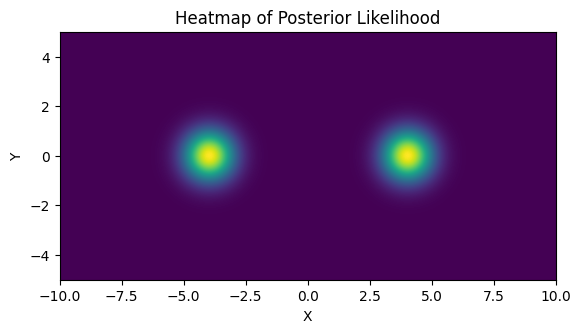

Evidence from grid integration is 2.9883
